In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

In [2]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
    def forward(self, x_in):
        return torch.sigmoid(self.fc1(x_in))

In [3]:
LEFT_CENTER = (3,3)
RIGHT_CENTER = (3,-2)

def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    x_data = []
    y_labels = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=left_center))
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_labels[batch_i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_labels, dtype=torch.float32)

In [27]:
def visualize_results( model, x_data, true_labels, n_samples=1000, ax=None, epoch=None, title="",\
                     levels=[0.3,0.4,0.5], linestyles=['--','-','--']):
    predictions = model(x_data)
    predictions = (predictions > 0.5).long().data.numpy().astype(np.int32)
    
    x_data = x_data.data.numpy()
    true_labels = true_labels.data.numpy().astype(np.int32)
    
    n_classes = 2
    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ["black","white"]
    markers = ["o","*"]
    
    for x_i, predicted_i, true_i in zip(x_data, predictions, true_labels):
        all_x[true_i].append(x_i)
        if predicted_i == true_i:
            all_colors[true_i].append("white")
        else:
            all_colors[true_i].append("black")
    
    all_x = [np.stack(x_list) for x_list in all_x]
    
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10,10))
    
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:,0], x_list[:,1], edgecolor="black", marker=marker, facecolor=color_list, s=300)
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]),\
           max([x_list[:,0].max() for x_list in all_x]))
    
    ylim = (min([x_list[:,1].min() for x_list in all_x]),\
           max([x_list[:,1].max() for x_list in all_x]))
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy,xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = model(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX,YY, Z, colors='k', levels=levels, linestyles=linestyles)
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

(-0.5926523563833896,
 6.562096120385693,
 -5.983425993916757,
 6.3202304171523815)

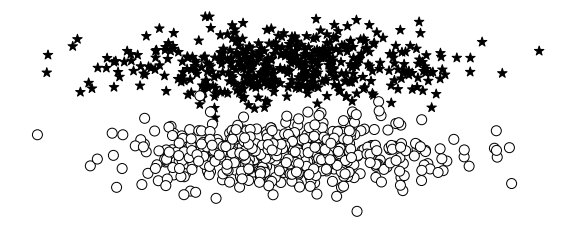

In [10]:
np.random.seed(2019)
x_data, y_true = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_true = y_true.data.numpy()

left_x = []
right_x = []
left_colors = []
right_colors = []

for x_i, y_true in zip(x_data, y_true):
    color = "black"
    if y_true == 0:
        left_x.append(x_i)
        left_colors.append(color)
    else:
        right_x.append(x_i)
        right_colors.append(color)
        
left_x = np.stack(left_x)
right_x = np.stack(right_x)

_, ax = plt.subplots(1,1, figsize=(10,4))

ax.scatter(left_x[:, 0], left_x[:, 1], color=left_colors, marker="*", s=100)
ax.scatter(right_x[:, 0], right_x[:, 1], facecolor="white", edgecolor=right_colors, marker="o", s=100)
plt.axis("off")

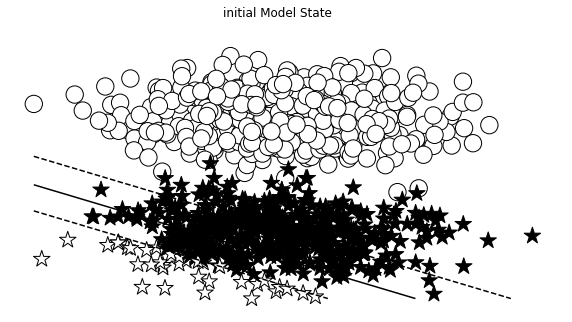

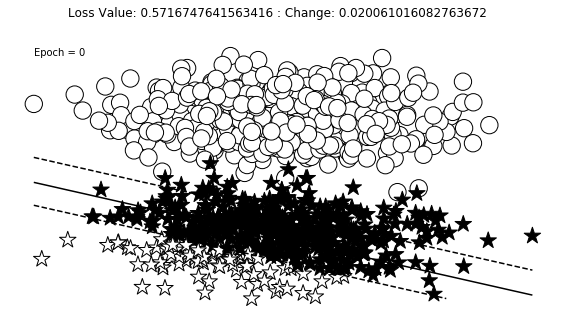

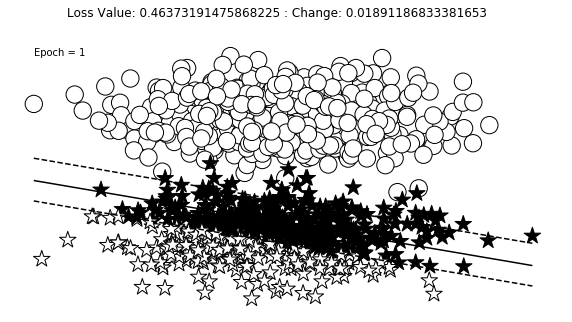

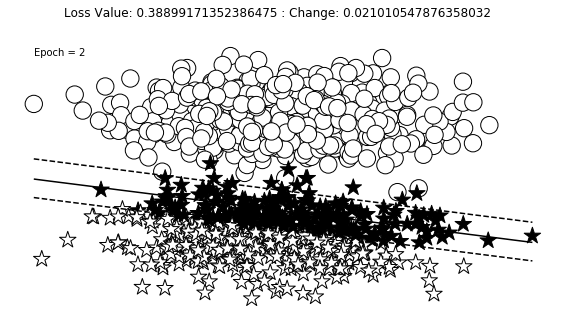

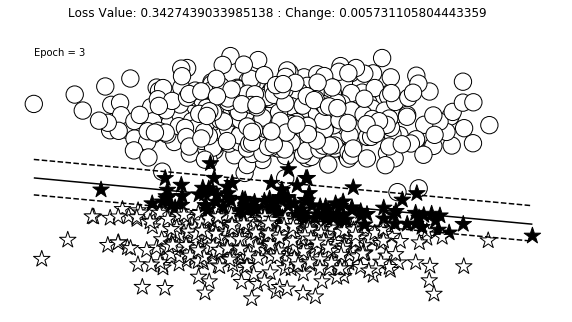

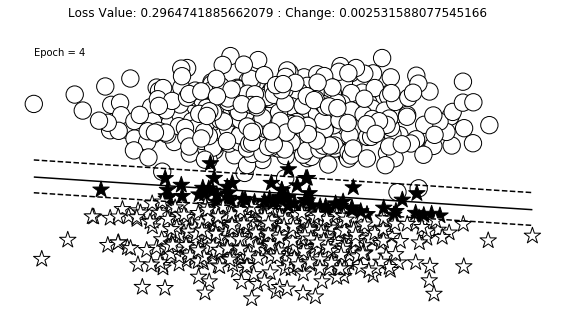

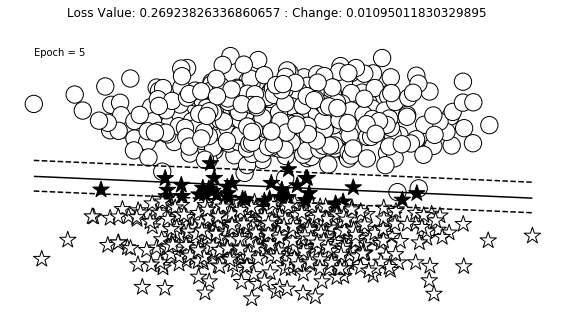

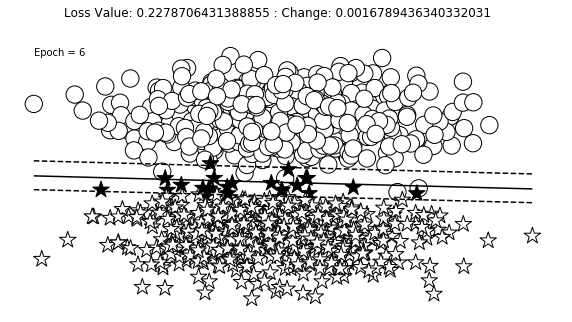

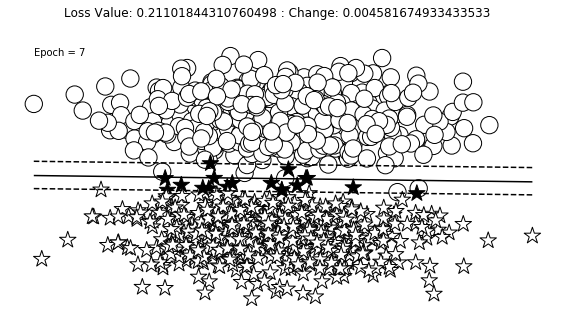

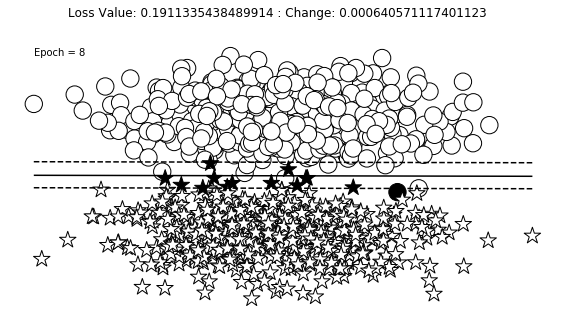

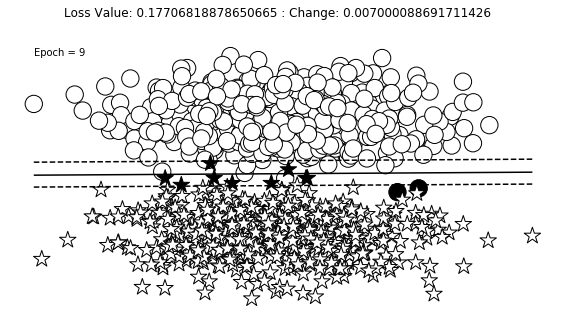

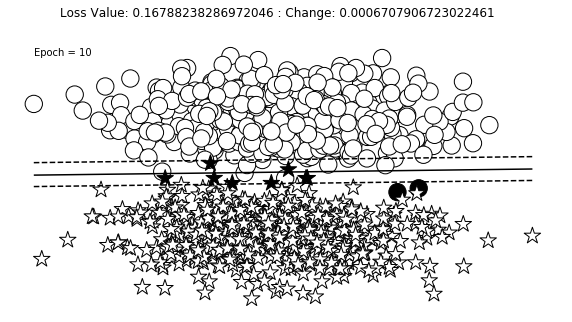

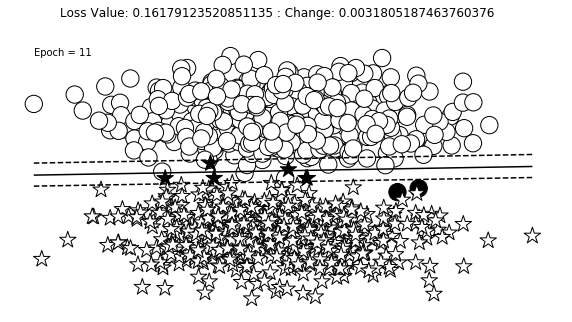

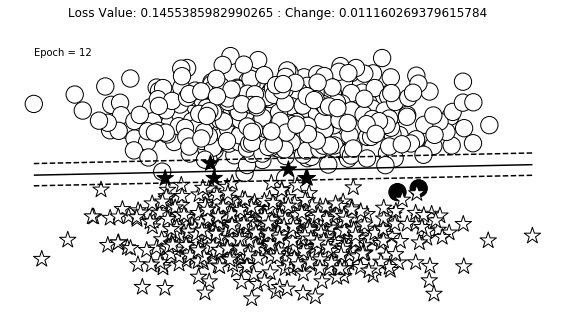

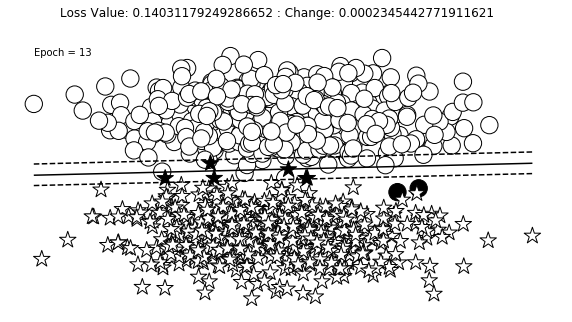

In [28]:
lr = 0.01
input_dim = 2

batch_size = 1000
n_epochs = 12
n_batches = 5

model = Perceptron(input_dim=input_dim)
optimizer = optim.Adam(params=model.parameters(), lr=lr)
bce_loss = nn.BCELoss()

losses = []

x_data_static, y_truth_static = get_toy_data(batch_size)

fig, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(model, x_data_static, y_truth_static, ax=ax, title="initial Model State")

plt.axis("off")

change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0
while change > epsilon or epoch < n_epochs or last > 0.3:
    for _ in range(n_batches):
        optimizer.zero_grad()
        x_data, y_target= get_toy_data(batch_size)
        predictions = model(x_data).squeeze()
        loss = bce_loss(predictions, y_target)
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        losses.append(loss_value)
        
        change = abs(last - loss_value)
        last = loss_value
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    visualize_results(model, x_data_static, y_truth_static, ax=ax, epoch=epoch, \
                     title="Loss Value: {} : Change: {}".format(loss_value, change))
    
    plt.axis("off")
    epoch += 1

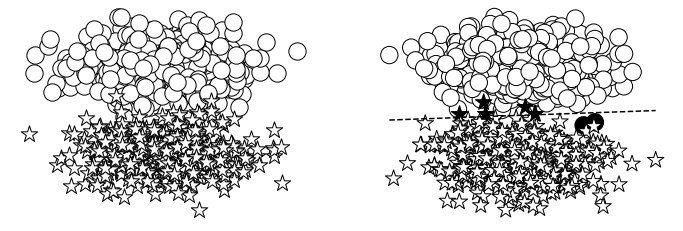

In [30]:
_, axes = plt.subplots(1,2,figsize=(12,4))


axes[0].scatter(left_x[:, 0], left_x[:, 1], facecolor='white',edgecolor='black', marker='o', s=300)
axes[0].scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor='black', marker='*', s=300)
axes[0].axis('off');
visualize_results(model, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
axes[1].axis('off');